# Dataset Exploration

In [33]:
import os

default_n_threads = 8
os.environ["OPENBLAS_NUM_THREADS"] = f"{default_n_threads}"
os.environ["MKL_NUM_THREADS"] = f"{default_n_threads}"
os.environ["OMP_NUM_THREADS"] = f"{default_n_threads}"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Executive Summary

In order to prepare for **RQ6** (Is model similarity enough to detect poisoning attacks?), play around with the dataset and understand its characteristics, such as:

- Number of unique IPs
- Attack repartition per IP

In [34]:
import pandas as pd

df = pd.read_csv("../../data/nfv2/sampled/cicids.csv.gz")
# df = pd.read_csv("../../data/nfv2/origin/NF-CSE-CIC-IDS2018-v2.csv.gz")

In [35]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,212.92.115.177,49171,172.31.68.13,3389,6,0.000,1460,8,2126,10,...,64000,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
1,212.92.116.6,60992,172.31.67.115,3389,6,0.000,1830,10,3600,12,...,64000,29184,114,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
2,172.31.65.117,54899,172.31.0.2,53,17,5.126,71,1,87,1,...,0,0,0,45060,1,60,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
3,172.31.67.56,51920,209.85.202.113,80,6,7.126,1136,17,1450,15,...,42780,49920,195,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4,5.101.40.43,60596,172.31.67.24,3389,6,0.000,1460,8,1873,7,...,64000,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2


In [36]:
protocol_map = {
    6: "TCP",
    17: "UDP",
    1: "ICMP",
    2: "IGMP",  # Internet Group Management Protocol (used for multicast)
    58: "ICMPv6",
    47: "GRE",  # Generic Routing Encapsulation (Cisco tunneling protocol)
}
df["PROTOCOL"].value_counts().rename(index=protocol_map)

PROTOCOL
TCP       585038
UDP       413795
ICMP        1040
IGMP          74
ICMPv6        51
GRE            2
Name: count, dtype: int64

In [37]:
df[df["Label"] == 0]["L7_PROTO"].round().astype(int).value_counts()[lambda x: x > 100]

L7_PROTO
0      580211
5      125605
91      69232
7       57175
41      27810
77       7920
88       3721
92       2928
131      1907
6         962
10        543
20        342
89        311
114       255
40        175
1         160
Name: count, dtype: int64

Text(0.5, 0.98, 'Explained variance ratio of the principal components')

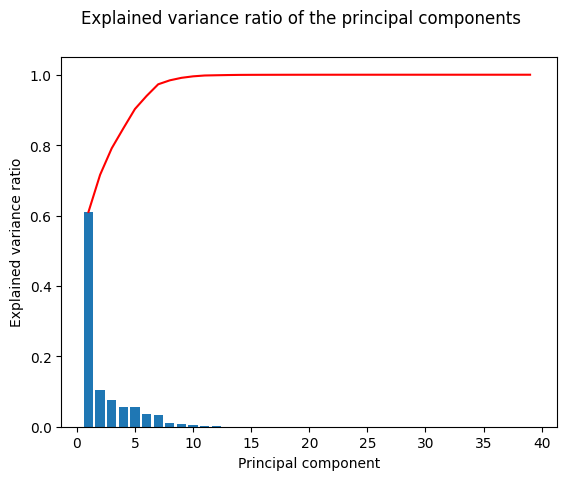

In [38]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def prepare(df) -> pd.DataFrame:
    RM_COLS = [
        "IPV4_SRC_ADDR",
        "L4_SRC_PORT",
        "IPV4_DST_ADDR",
        "L4_DST_PORT",
        "Label",
        "Attack",
    ]

    if "Dataset" in df.columns:
        RM_COLS += ["Dataset"]

    # select the columns to compose the Dataset object
    X = df.drop(columns=RM_COLS)

    # convert classes to numerical values
    X = pd.get_dummies(X)

    # normalize the data
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    scaler.fit(X)
    X[X.columns] = scaler.transform(X)

    # NaN values are replaced by 0
    X = X.fillna(0)

    return X


X = prepare(df[df["Label"] == 0])

pca = PCA()
pca.fit(X)

fig, ax = plt.subplots()
# plot the explained variance per principal component
ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
ax.set_ylabel("Explained variance ratio")
# plot the cumulative explained variance
ax.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_.cumsum(),
    c="red",
)

ax.set_xlabel("Principal component")
fig.suptitle("Explained variance ratio of the principal components")

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components)')

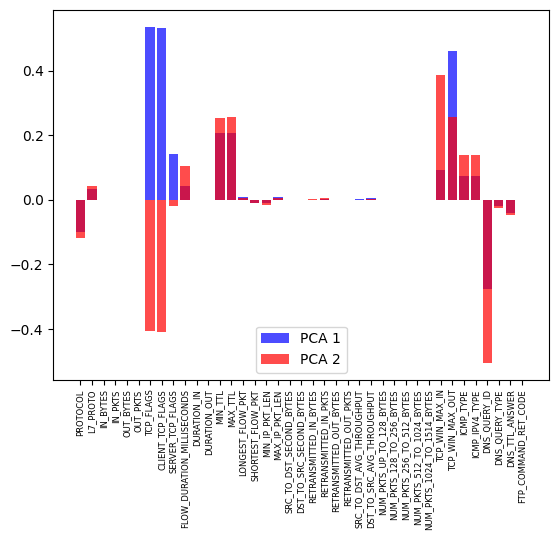

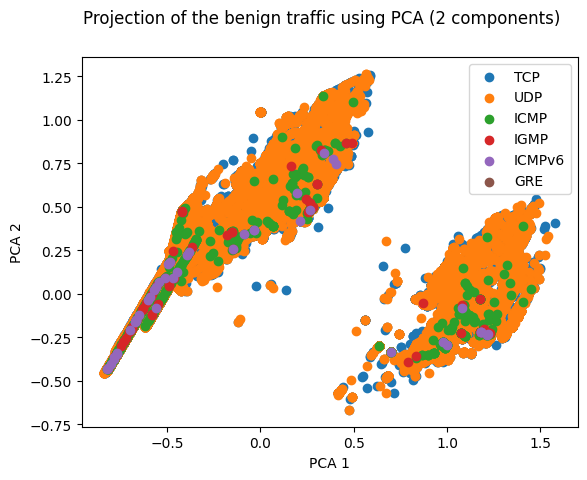

In [47]:
pca = PCA(n_components=2)
pca.fit(X)
# plot the feature importance of the first two components on a grouped bar plot using offset
# one color per component, feature names on x-axis (rotated 90, and small font size to
# fit all features)
fig, ax = plt.subplots()

ax.set_xticks(range(1, len(pca.components_[0]) + 1))
ax.set_xticklabels(X.columns, rotation=90, fontsize=6)
ax.legend()

# plot the pca colored by the protocol
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns=["pca1", "pca2"])

fig, ax = plt.subplots()

for protocol in df["PROTOCOL"].unique():
    mask = df["PROTOCOL"] == protocol
    ax.scatter(
        X_pca.loc[mask, "pca1"],
        X_pca.loc[mask, "pca2"],
        label=protocol_map[protocol] if protocol in protocol_map else protocol,
    )
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.legend()
fig.suptitle("Projection of the benign traffic using PCA (2 components)")

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=10, init="k-means++", n_init=10)

kmeans.fit(X)
clusters = pd.DataFrame(kmeans.predict(X), columns=["X"])

kmeans.fit(X_pca)
clusters["X_pca"] = kmeans.predict(X_pca)

clusters["X"]

# rand index between "X" and "X_pca"
adjusted_rand_score(clusters["X"], clusters["X_pca"])

0.5435494579665576

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components) colored by cluster')

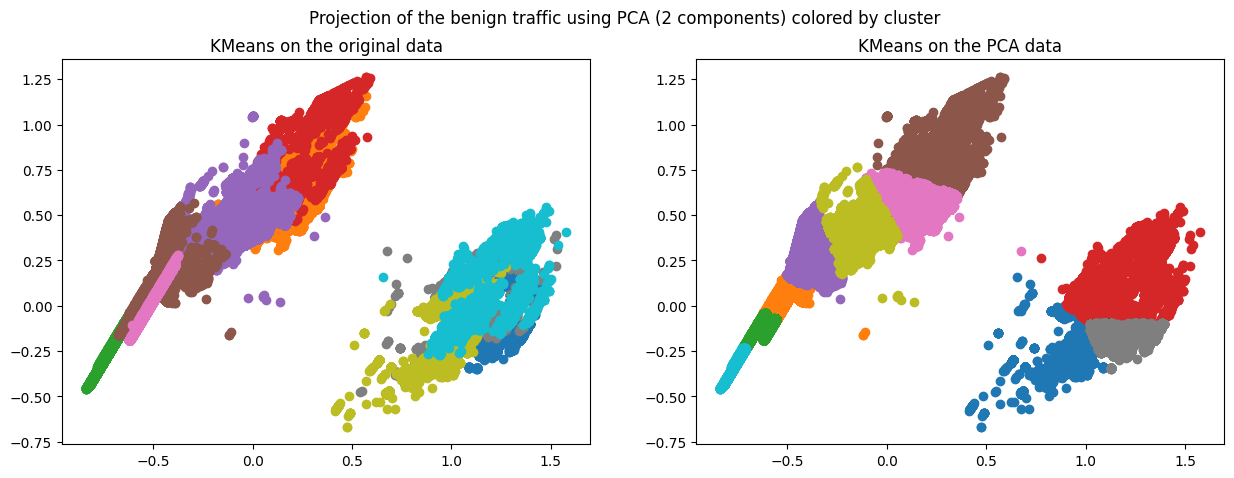

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))

# plot the pca colored by the cluster
for cluster in clusters["X"].unique():
    mask = clusters["X"] == cluster
    ax0.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax0.set_title("KMeans on the original data")
    mask = clusters["X_pca"] == cluster
    ax1.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax1.set_title("KMeans on the PCA data")


ax.legend()
fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)

In [42]:
# reindex the clusters by size
clusters_map = pd.DataFrame(
    pd.concat(
        [
            pd.Series(clusters["X"].value_counts().sort_values().index),
            pd.Series(clusters["X_pca"].value_counts().sort_values().index),
        ],
        axis=1,
    ),
    columns=["X", "X_pca"],
)

clusters["X"] = clusters["X"].map(
    {v: k for k, v in clusters_map["X"].to_dict().items()}
)
clusters["X_pca"] = clusters["X_pca"].map(
    {v: k for k, v in clusters_map["X_pca"].to_dict().items()}
)

counts = pd.DataFrame(
    [clusters["X"].value_counts(), clusters["X_pca"].value_counts()]
).T
counts.columns = ["X", "X_pca"]
counts.sort_index()

,X,X_pca
0,13954,32985
1,20724,40006
2,33021,54518
3,64313,55999
4,68779,65957
5,76013,78205
6,115304,128047
7,120988,136200
8,180070,139468
9,187457,149238


In [43]:
sum(counts["X"]), sum(counts["X_pca"])

(880623, 880623)

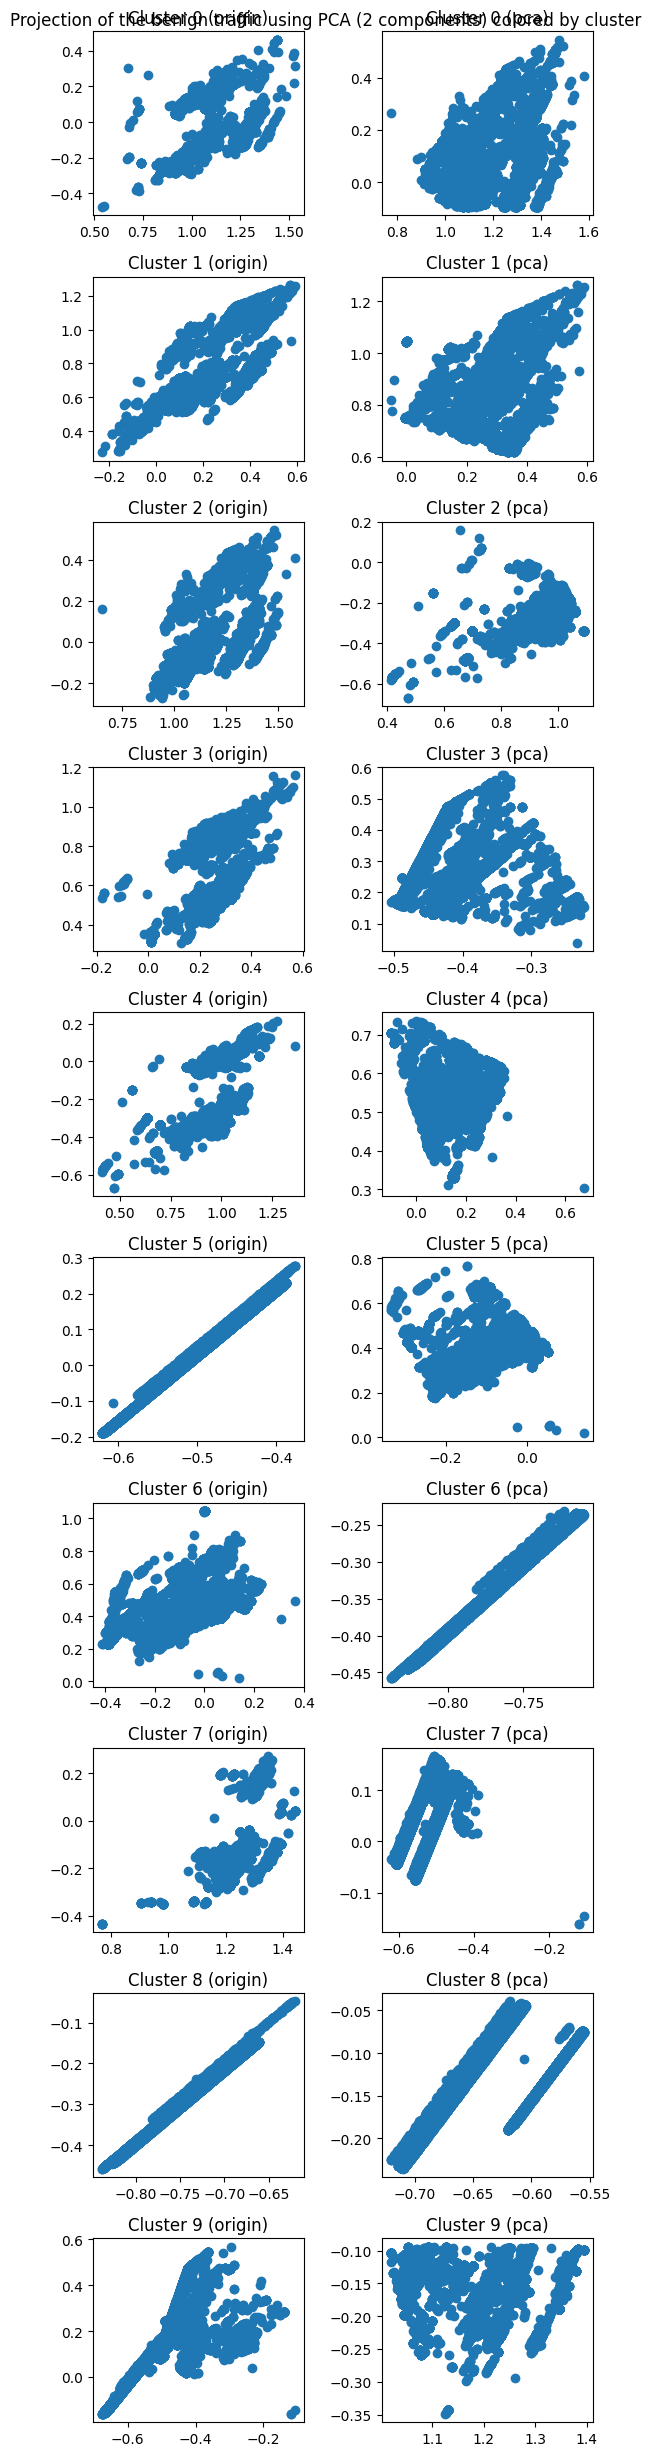

In [44]:
fig, axs = plt.subplots(10, 2, figsize=(6, 25))

for cluster in range(10):
    mask = clusters["X"] == cluster
    axs[cluster, 0].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 0].set_title(f"Cluster {cluster} (origin)")
    mask = clusters["X_pca"] == cluster
    axs[cluster, 1].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 1].set_title(f"Cluster {cluster} (pca)")

fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)
fig.tight_layout()
plt.show()